In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
from numpy import load

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

In [ ]:
import os 

In [ ]:
!pwd

/content


In [ ]:
directory = '/content/drive/MyDrive/cv_fish_bonus/NA_Fish_Dataset'
clases = os.listdir(directory)

In [ ]:
clases

['Red Mullet',
 'Sea Bass',
 'Striped Red Mullet',
 'Shrimp',
 'Trout',
 'Black Sea Sprat',
 'Gilt Head Bream',
 'Horse Mackerel',
 'Red Sea Bream']

In [ ]:
directory = '/content/drive/MyDrive/cv_fish_bonus/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases: 
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [ ]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/cv_fish_bonus/NA_Fish_D...,Red Mullet
1,/content/drive/MyDrive/cv_fish_bonus/NA_Fish_D...,Red Mullet
2,/content/drive/MyDrive/cv_fish_bonus/NA_Fish_D...,Red Mullet
3,/content/drive/MyDrive/cv_fish_bonus/NA_Fish_D...,Red Mullet
4,/content/drive/MyDrive/cv_fish_bonus/NA_Fish_D...,Red Mullet


In [ ]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 430/430 [05:23<00:00,  1.33it/s]


In [ ]:
torch.cuda.is_available()

True

In [ ]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [ ]:
df['target'].unique()

array(['Red Mullet', 'Sea Bass', 'Striped Red Mullet', 'Shrimp', 'Trout',
       'Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel',
       'Red Sea Bream'], dtype=object)

In [ ]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [ ]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [ ]:
len(y_train)

344

In [ ]:
len(y_test)

86

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [ ]:
!pip -q install vit_pytorch linformer

     |████████████████████████████████| 42 kB 1.0 MB/s 


In [ ]:
from vit_pytorch.efficient import ViT
from linformer import Linformer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from vit_pytorch import ViT
from vit_pytorch.mpp import MPP
model = ViT(
    image_size=256,
    patch_size=32,
    dim=1024,
    depth=6,
    heads=8,
    mlp_dim=2048,
    dropout=0.1,
    emb_dropout=0.1,
    channels = 3,
    num_classes = 9
).cuda()
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
import tqdm
error = []
for epoch in range(40):
        print('epoch: ------', epoch)
        for ind, batch in enumerate(tqdm.tqdm(trainloader)):
          imgs,  label= batch
          images = imgs
          images = images.to(device=device, dtype=torch.float32)
          label = label.to(device = device, dtype = torch.long)
          output = model(images)
          loss = criterion(output, label)
          if(ind ==0): 
            error.append(loss)
            print(loss)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

epoch: ------ 0


  1%|          | 1/86 [00:00<00:20,  4.08it/s]

tensor(3.1800, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:07<00:00, 12.04it/s]


epoch: ------ 1


  2%|▏         | 2/86 [00:00<00:06, 13.49it/s]

tensor(2.4452, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.49it/s]


epoch: ------ 2


  2%|▏         | 2/86 [00:00<00:05, 14.09it/s]

tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.48it/s]


epoch: ------ 3


  2%|▏         | 2/86 [00:00<00:05, 14.00it/s]

tensor(2.1494, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.47it/s]


epoch: ------ 4


  2%|▏         | 2/86 [00:00<00:06, 13.58it/s]

tensor(1.8938, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.48it/s]


epoch: ------ 5


  2%|▏         | 2/86 [00:00<00:06, 13.31it/s]

tensor(1.4816, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.44it/s]


epoch: ------ 6


  2%|▏         | 2/86 [00:00<00:06, 13.40it/s]

tensor(1.2319, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.43it/s]


epoch: ------ 7


  2%|▏         | 2/86 [00:00<00:06, 13.49it/s]

tensor(0.8068, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.42it/s]


epoch: ------ 8


  2%|▏         | 2/86 [00:00<00:06, 13.63it/s]

tensor(0.5743, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.41it/s]


epoch: ------ 9


  2%|▏         | 2/86 [00:00<00:06, 13.90it/s]

tensor(0.8241, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.39it/s]


epoch: ------ 10


  2%|▏         | 2/86 [00:00<00:06, 13.95it/s]

tensor(0.4348, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 11


  2%|▏         | 2/86 [00:00<00:05, 14.08it/s]

tensor(0.6103, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.39it/s]


epoch: ------ 12


  2%|▏         | 2/86 [00:00<00:06, 13.95it/s]

tensor(0.2080, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 13


  2%|▏         | 2/86 [00:00<00:06, 13.66it/s]

tensor(0.3689, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 14


  2%|▏         | 2/86 [00:00<00:06, 13.77it/s]

tensor(0.1026, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 15


  2%|▏         | 2/86 [00:00<00:06, 13.66it/s]

tensor(0.1154, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 16


  2%|▏         | 2/86 [00:00<00:06, 12.85it/s]

tensor(0.1900, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 17


  2%|▏         | 2/86 [00:00<00:06, 13.51it/s]

tensor(0.8847, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 18


  2%|▏         | 2/86 [00:00<00:05, 14.28it/s]

tensor(0.1882, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 19


  2%|▏         | 2/86 [00:00<00:05, 14.15it/s]

tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 20


  2%|▏         | 2/86 [00:00<00:06, 13.94it/s]

tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 21


  2%|▏         | 2/86 [00:00<00:06, 13.30it/s]

tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 22


  2%|▏         | 2/86 [00:00<00:06, 13.78it/s]

tensor(0.0618, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 23


  2%|▏         | 2/86 [00:00<00:06, 13.87it/s]

tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 24


  2%|▏         | 2/86 [00:00<00:06, 13.41it/s]

tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 25


  2%|▏         | 2/86 [00:00<00:06, 13.58it/s]

tensor(0.0190, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 26


  2%|▏         | 2/86 [00:00<00:06, 13.89it/s]

tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 27


  2%|▏         | 2/86 [00:00<00:05, 14.22it/s]

tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 28


  2%|▏         | 2/86 [00:00<00:06, 13.58it/s]

tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 29


  2%|▏         | 2/86 [00:00<00:06, 13.01it/s]

tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 30


  2%|▏         | 2/86 [00:00<00:06, 13.44it/s]

tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 31


  2%|▏         | 2/86 [00:00<00:06, 13.80it/s]

tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 32


  2%|▏         | 2/86 [00:00<00:05, 14.19it/s]

tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 33


  2%|▏         | 2/86 [00:00<00:06, 13.11it/s]

tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.35it/s]


epoch: ------ 34


  2%|▏         | 2/86 [00:00<00:05, 14.45it/s]

tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 35


  2%|▏         | 2/86 [00:00<00:06, 13.75it/s]

tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.36it/s]


epoch: ------ 36


  2%|▏         | 2/86 [00:00<00:05, 14.48it/s]

tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.34it/s]


epoch: ------ 37


  2%|▏         | 2/86 [00:00<00:05, 14.13it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.37it/s]


epoch: ------ 38


  2%|▏         | 2/86 [00:00<00:06, 13.78it/s]

tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


epoch: ------ 39


  2%|▏         | 2/86 [00:00<00:05, 14.04it/s]

tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 86/86 [00:06<00:00, 12.38it/s]


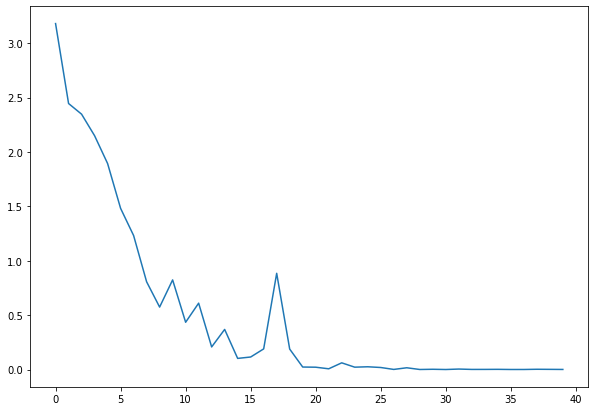

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(error)), error)
plt.show()

In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm.tqdm(testloader):
        img_np, label = data
        img = img_np.to(device=device, dtype=torch.float32)
        output = model(img)
        for i in range(len(output)):
          y_pred.append(output[i])
          y_true.append(label[i])

100%|██████████| 22/22 [00:00<00:00, 35.01it/s]


In [ ]:
y_pred[:5]

[tensor([ 1.4125,  9.3329, -1.5047, -4.0690,  0.3028, -3.1762,  3.1990, -2.6253,
         -2.4540], device='cuda:0'),
 tensor([-4.9197, -0.7887,  0.7230, -5.2908, -2.1967, -3.0824, 10.0105,  2.3082,
          2.3878], device='cuda:0'),
 tensor([ 1.8715, -9.7211,  6.9796, -3.2744, -0.8838,  1.6459, -0.3648, -0.3542,
          4.7449], device='cuda:0'),
 tensor([-0.9029,  3.2669,  1.1726, -1.1969, -7.1359, 10.9867, -3.8486,  2.9103,
         -4.7891], device='cuda:0'),
 tensor([ 4.1843, -4.1694,  6.4753, -0.3636, -3.0403,  8.0644, -2.8748, -3.2006,
         -4.8035], device='cuda:0')]

In [ ]:
y_true[:5]

[tensor(1), tensor(6), tensor(8), tensor(5), tensor(5)]

In [ ]:
y_true[0].item()

1

In [ ]:
test = []
for i in y_true:
  test.append(i.item())

In [ ]:
pred = []
for i in y_pred:
  pred.append(np.argmax(i.cpu().numpy()))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[ 7  0  2  0  0  0  0  0  1]
 [ 0  7  1  0  2  0  0  1  0]
 [ 0  0  8  0  0  0  0  1  1]
 [ 1  0  0  9  0  0  0  0  0]
 [ 0  1  0  0  6  0  0  0  1]
 [ 0  0  0  0  0  8  0  0  0]
 [ 0  2  0  0  0  0 12  1  0]
 [ 0  0  0  0  0  1  0  3  0]
 [ 0  0  1  1  0  0  0  0  8]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.70      0.64      0.67        11
           2       0.67      0.80      0.73        10
           3       0.90      0.90      0.90        10
           4       0.75      0.75      0.75         8
           5       0.89      1.00      0.94         8
           6       1.00      0.80      0.89        15
           7       0.50      0.75      0.60         4
           8       0.73      0.80      0.76        10

    accuracy                           0.79        86
   macro avg       0.78      0.79      0.78        86
weighted avg       0.81      0.79      0.79        86



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred))

[[ 7  0  2  0  0  0  0  0  1]
 [ 0  7  1  0  2  0  0  1  0]
 [ 0  0  8  0  0  0  0  1  1]
 [ 1  0  0  9  0  0  0  0  0]
 [ 0  1  0  0  6  0  0  0  1]
 [ 0  0  0  0  0  8  0  0  0]
 [ 0  2  0  0  0  0 12  1  0]
 [ 0  0  0  0  0  1  0  3  0]
 [ 0  0  1  1  0  0  0  0  8]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.70      0.64      0.67        11
           2       0.67      0.80      0.73        10
           3       0.90      0.90      0.90        10
           4       0.75      0.75      0.75         8
           5       0.89      1.00      0.94         8
           6       1.00      0.80      0.89        15
           7       0.50      0.75      0.60         4
           8       0.73      0.80      0.76        10

    accuracy                           0.79        86
   macro avg       0.78      0.79      0.78        86
weighted avg       0.81      0.79      0.79        86

